Epoch 1/20, Average Loss: 0.8021


Epoch 2/20, Average Loss: 0.5451


Epoch 3/20, Average Loss: 0.4723


Epoch 4/20, Average Loss: 0.4583


Epoch 5/20, Average Loss: 0.4380


Epoch 6/20, Average Loss: 0.4125


Epoch 7/20, Average Loss: 0.3570


Epoch 8/20, Average Loss: 0.3136


Epoch 9/20, Average Loss: 0.3483


Epoch 10/20, Average Loss: 0.3649


Epoch 11/20, Average Loss: 0.2659


Epoch 12/20, Average Loss: 0.3143


Epoch 13/20, Average Loss: 0.3191


Epoch 14/20, Average Loss: 0.2816


Epoch 15/20, Average Loss: 0.2634


Epoch 16/20, Average Loss: 0.1819


Epoch 17/20, Average Loss: 0.2142


Epoch 18/20, Average Loss: 0.1923


Epoch 19/20, Average Loss: 0.2114


Epoch 20/20, Average Loss: 0.1834


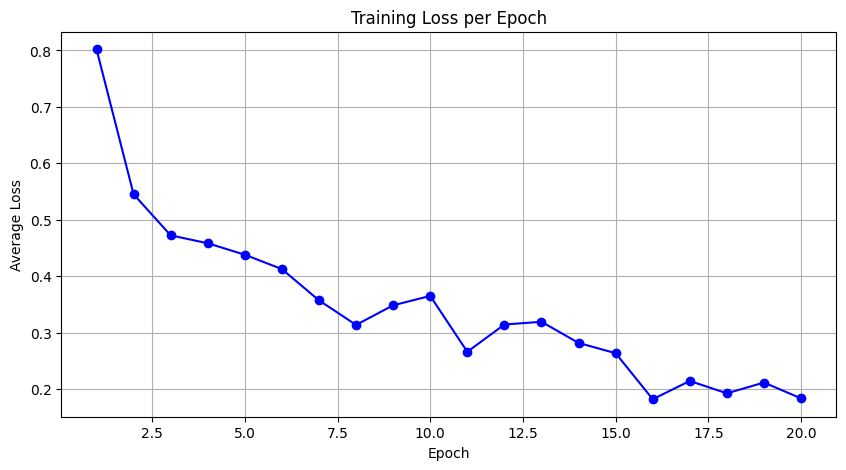

Test Accuracy: 81.48%


In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set random seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the 18 landmarks in the order they appear in your CSV
landmark_order = [
    "Nose", "Neck", "Right Shoulder", "Right Elbow", "Right Wrist",
    "Left Shoulder", "Left Elbow", "Left Wrist", "Right Hip", "Right Knee",
    "Right Ankle", "Left Hip", "Left Knee", "Left Ankle", "Right Eye",
    "Left Eye", "Right Ear", "Left Ear"
]

# Spatial graph edges for 18 joints (same as before, adjusted for index mapping)
edges = [
    (0, 1),   # Nose to Neck
    (1, 2),   # Neck to Right Shoulder
    (2, 3),   # Right Shoulder to Right Elbow
    (3, 4),   # Right Elbow to Right Wrist
    (1, 5),   # Neck to Left Shoulder
    (5, 6),   # Left Shoulder to Left Elbow
    (6, 7),   # Left Elbow to Left Wrist
    (1, 8),   # Neck to Right Hip
    (8, 9),   # Right Hip to Right Knee
    (9, 10),  # Right Knee to Right Ankle
    (1, 11),  # Neck to Left Hip
    (11, 12), # Left Hip to Left Knee
    (12, 13), # Left Knee to Left Ankle
    (0, 14),  # Nose to Right Eye
    (0, 15),  # Nose to Left Eye
    (14, 16), # Right Eye to Right Ear
    (15, 17)  # Left Eye to Left Ear
]

# Function to process a single CSV file into a skeleton sequence
def process_csv_to_skeleton(csv_path):
    # Read CSV
    df = pd.read_csv(csv_path)
    
    # Ensure all 30 frames and 18 landmarks are present
    skeleton_sequence = np.zeros((30, 18, 3))  # Shape: (frames, joints, coords)
    
    # Group by frame
    for frame in range(30):
        frame_data = df[df['frame'] == frame]
        if frame_data.empty:
            continue  # Leave as zeros if frame is missing
        
        # Map landmarks to the correct order
        for i, landmark in enumerate(landmark_order):
            landmark_data = frame_data[frame_data['landmark'] == landmark]
            if not landmark_data.empty:
                skeleton_sequence[frame, i] = landmark_data[['x', 'y', 'z']].values[0]
            # If landmark is missing, it remains zero
    
    assert skeleton_sequence.shape == (30, 18, 3), f"Unexpected shape: {skeleton_sequence.shape} for {csv_path}"
    return skeleton_sequence

# Dataset Class
class FallDataset(Dataset):
    def __init__(self, fall_dir, no_fall_dir):
        self.data = []
        self.labels = []
        
        # Process FallDataset (label = 1)
        for root, _, files in os.walk(fall_dir):
            for csv_file in files:
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(root, csv_file)
                    skeleton = process_csv_to_skeleton(csv_path)
                    self.data.append(skeleton)
                    self.labels.append(1)
        
        # Process NoFallDataset (label = 0)
        for root, _, files in os.walk(no_fall_dir):
            for csv_file in files:
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(root, csv_file)
                    skeleton = process_csv_to_skeleton(csv_path)
                    self.data.append(skeleton)
                    self.labels.append(0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        skeleton = torch.tensor(self.data[idx], dtype=torch.float32).permute(2, 0, 1)  # (C, T, V) = (3, 30, 18)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return skeleton, label

# ST-GCN Model (unchanged)
class STGCN(nn.Module):
    def __init__(self, in_channels=3, num_joints=18, num_classes=2, graph_edges=None):
        super(STGCN, self).__init__()
        self.graph_edges = graph_edges
        self.num_joints = num_joints
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 1), padding=(1, 0))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 1), padding=(1, 0))
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d((1, num_joints))
        self.fc = nn.Linear(128 * num_joints, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):

    model.train()
    epoch_losses = []  # Store average loss per epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        # Wrap train_loader with tqdm for progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Update progress bar with current batch loss
            progress_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
        
        # Calculate and store average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    # Plot the loss graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

    return epoch_losses

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Main Execution
if __name__ == "__main__":
    # Update these paths to your actual CSV directories
    fall_dir = "processed/fall/csv"
    no_fall_dir = "processed/nofall/csv"
    
    # Create dataset and split
    dataset = FallDataset(fall_dir, no_fall_dir)
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Initialize model, loss, and optimizer
    model = STGCN(in_channels=3, num_joints=18, num_classes=2, graph_edges=edges).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train and evaluate
    train_model(model, train_loader, criterion, optimizer, num_epochs=20)
    evaluate_model(model, test_loader)
    
    # Save the model
    torch.save(model.state_dict(), "Models/stgcn_fall_detection.pth")